# VST ATLAS

In [1]:
import mclearn
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.cross_validation import KFold
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
plt.style.use('ggplot')

We start by preparing the data and put it in an HDF5 Store.

In [ ]:
sources = ['data/vstatlas/lib_WD___AT.fits',
           'data/vstatlas/lib_gal__AT.fits',
           'data/vstatlas/lib_qso__AT.fits',
           'data/vstatlas/lib_star_AT.fits']

classes = ['White Dwarf', 'Galaxy', 'Quasar', 'Star']

# a-priori likelihood for a random object in the sky
likelihoods = [590. / 3. * 38,
               6559. / 127. * 2496,
               2303. / 5. * 16,
               25602. / 697. * 14868]

dfs = []

for source, obj in zip(sources, classes):
    data = fits.open(source)
    df = pd.DataFrame(data[1].data)
    df['class'] = obj
    dfs.append(df)
    
vstatlas = pd.concat(dfs, axis=0, ignore_index=True)
vstatlas = vstatlas[['class', 'rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']]
vstatlas = vstatlas.iloc[np.random.permutation(len(vstatlas))]
vstatlas = vstatlas.reset_index(drop=True)
vstatlas.to_hdf('data/vstatlas.h5', 'vstatlas')

Let's now read in the data.

In [2]:
vstatlas = pd.read_hdf('data/vstatlas.h5', 'vstatlas')
fig_dir = '../reports/alasdair/thesis/figures/'
target_col = 'class'
feature_cols = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

In [3]:
vstatlas.head()

,class,rmagC,umg,gmr,rmi,imz,rmw1,w1m2
0,Star,18.900099,2.527203,1.235399,0.541201,0.420200,0.430900,-0.725000
1,Star,19.546499,2.829502,1.442698,0.774500,0.558801,0.644199,-0.447201
2,Star,18.818100,0.952703,0.267597,0.033401,0.045199,-99.000000,-99.000000
3,Star,18.955101,1.006903,0.366797,0.140499,0.123499,-99.000000,-99.000000
4,Star,19.153099,3.097002,1.265000,0.431900,0.419700,0.045599,-0.903999


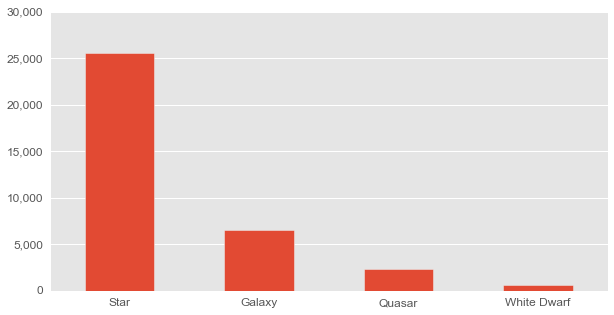

In [4]:
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_class_distribution(vstatlas[target_col])
fig.savefig(fig_dir + 'bar_vstatlas_class_distribution.pdf', bbox_inches='tight')

In [5]:
vstatlas[target_col].value_counts()

Star           25604
Galaxy          6559
Quasar          2303
White Dwarf      590
dtype: int64

In [ ]:
# obtain a pool of 569*4 examples
X, _, y, _ = mclearn.balanced_train_test_split(
    vstatlas, feature_cols, target_col, train_size=589, test_size=1, random_state=2)
X, y = shuffle(X, y, random_state=14)

# scale data to zero mean and unit variance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

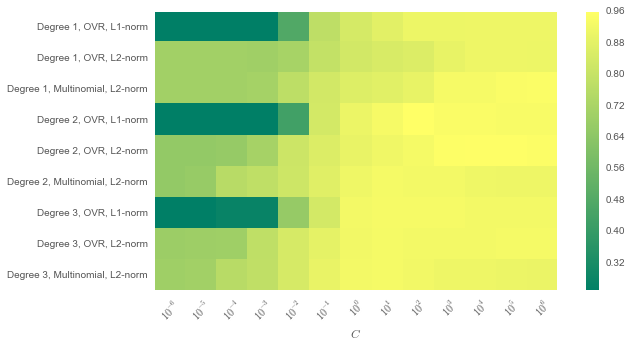

In [10]:
mclearn.grid_search_logistic(X_scaled, y, train_size=1000, test_size=1000,
     fig_path=fig_dir+'heat_vstatlas_vgridsearch_logistic.pdf',
     pickle_path='pickle/07_vstatlas/vstatlas_grid_scores_logistic.pickle')

In [ ]:
# initialise the main classifier
logistic_classifier = LogisticRegression(multi_class='ovr', penalty='l1', C=100,
                                         random_state=2, class_weight='auto')

# list of all heuristics to be used (and the paths where results are saved)
heuristics = [mclearn.random_h, mclearn.entropy_h, mclearn.margin_h,
              mclearn.qbb_margin_h, mclearn.qbb_kl_h]
curve_labels = ['Random', 'Entropy', 'Margin', 'QBB Margin', 'QBB KL']

# set up the logistic committee
committee = []
committee_size = 11
for i in range(committee_size):
    member = LogisticRegression(multi_class='ovr', penalty='l1', C=1,
                                random_state=2, class_weight='auto')
    committee.append(member)
    
pickle_paths = ['pickle/07_vstatlas/default_random.pickle',
                'pickle/07_vstatlas/default_entropy.pickle',
                'pickle/07_vstatlas/default_margin.pickle',
                'pickle/07_vstatlas/default_qbb_margin.pickle',
                'pickle/07_vstatlas/default_qbb_kl.pickle']

classes = ['White Dwarf', 'Galaxy', 'Quasar', 'Star']

scaler = StandardScaler()
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

X_scaled = scaler.fit_transform(vstatlas[feature_cols])
X_poly = transformer.fit_transform(X_scaled)
y = np.array(vstatlas[target_col])

kfold = KFold(n=len(y), n_folds=5, shuffle=False, random_state=13)

In [ ]:
for heuristic, pickle_path in zip(heuristics, pickle_paths):
    learning_curves = []
    for train_index, test_index in kfold:
        training_pool = X_poly[train_index]
        testing_pool = X_poly[test_index]
        training_oracle = y[train_index]
        testing_oracle = y[test_index]

        learning_curve = mclearn.active_learn(
            training_pool, testing_pool, training_oracle, testing_oracle,
            total_n=1000, initial_n=20, random_n=len(y),
            active_learning_heuristic=heuristic, classifier=logistic_classifier,
            compute_accuracy=mclearn.performance.compute_balanced_accuracy,
            classes=classes, committee=committee, bag_size=1000, verbose=True)
        
        learning_curves.append(learning_curve)
    print('\n')
    
    with open(pickle_path, 'wb') as f:
        pickle.dump(learning_curves, f, protocol=4) 

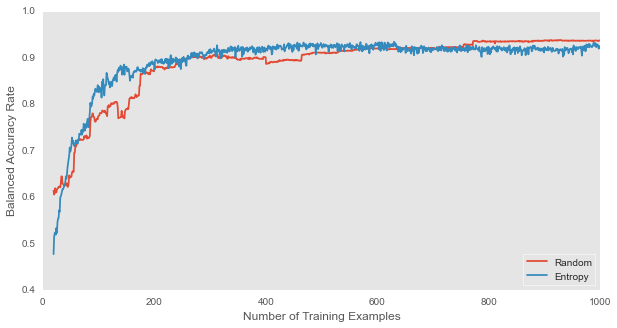

In [8]:
learning_curves = []
for pickle_path in pickle_paths:
    with open(pickle_path, 'rb') as f:
        learning_curves.append(pickle.load(f))
        
fig = plt.figure(figsize=(10, 5))
ax = mclearn.plot_average_learning_curve(np.arange(20, 1001), learning_curves, curve_labels)
fig.savefig(fig_dir+'lc_active_logistic_vstatlas.pdf', bbox_inches='tight')